In [2]:
import numpy as np
import h5py

f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
              +",FALSE,1/deeplift.imp_score.h5", "r")
#f = h5py.File("/users/avanti/deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [3]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

In [12]:
%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

%matplotlib inline

TF-MoDISco is using the TensorFlow backend.
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [45]:
from collections import OrderedDict
import numpy as np
import scipy.stats

def per_sequence_zscore(score_track, central=slice(400,600)):       
    transformed_all_scores = []                                                 
    for scores_row in score_track:                                              
        median = np.median(scores_row[central])                                          
        mad = scipy.stats.median_absolute_deviation(scores_row[central])                 
        transformed_all_scores.append((scores_row-median)/mad)           
    return transformed_all_scores


def per_sequence_zscore_log_percentile_transform(score_track, seed=1234):       
    score_track = per_sequence_zscore(score_track)
    transformed_all_scores = []
    for scores_row in score_track:                                              
        transformed_all_scores.append(                                          
         -np.log((1-(scipy.stats.norm.cdf(x=scores_row))) + 1e-16 ))           
    return transformed_all_scores 


transformed_perseq =\
    np.array(per_sequence_zscore_log_percentile_transform(
        #max_num_to_use_for_percentile=20000,
        score_track=[np.sum(s,axis=1) for s in nanog_profile_wn_contribs[:]]))

In [51]:
normal_perseq = np.array([np.sum(s,axis=1) for s in nanog_profile_wn_contribs[:]])

In [54]:
#let's do window sums for both, then find percentile ranking

def get_simple_window_sum_function(window_size):                                
    def window_sum_function(arrs):                                              
        to_return = []                                                          
        for arr in arrs:                                                        
            cumsum = np.cumsum(arr)                                             
            cumsum = np.array([0]+list(cumsum))                                 
            to_return.append(cumsum[window_size:]-cumsum[:-window_size])        
        return to_return                                                        
    return window_sum_function

window_size = 21
window_sum_function = get_simple_window_sum_function(window_size)
transformed_perseq_windowsum = np.array(window_sum_function(transformed_perseq))
normal_perseq_windowsum = np.array(window_sum_function(normal_perseq))

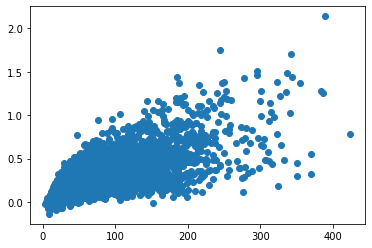

In [102]:
plt.scatter(transformed_perseq_windowsum.ravel()[::1000], normal_perseq_windowsum.ravel()[::1000])
plt.show()

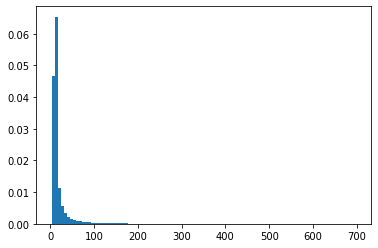

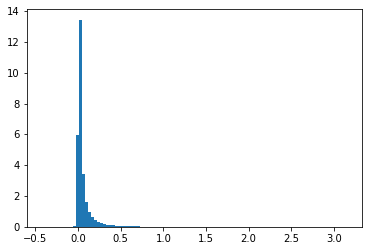

In [55]:
plt.hist(transformed_perseq_windowsum.ravel(), bins=100, density=True)
plt.show()
plt.hist(normal_perseq_windowsum.ravel(), bins=100, density=True)
plt.show()

In [108]:
def log_percentile(vals):
    raveled_vals = vals.ravel()
    subsample_size = 50000
    tosearch = sorted(np.random.RandomState(1234).choice(a=raveled_vals, replace=False, size=subsample_size))
    return -np.log((1-(np.searchsorted(a=tosearch, v=raveled_vals).reshape(vals.shape))/(subsample_size+1)))/np.log(10)

logperc_transformed_perseq_windowsum = log_percentile(transformed_perseq_windowsum)
logperc_normal_perseq_windowsum = log_percentile(normal_perseq_windowsum)

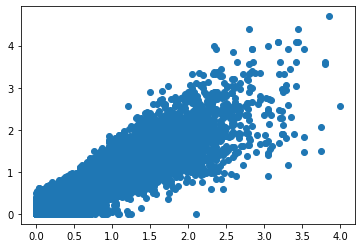

In [116]:
plt.scatter(logperc_transformed_perseq_windowsum.ravel()[::1000],
            logperc_normal_perseq_windowsum.ravel()[::1000])
plt.show()

In [139]:
transformed_rank_higher = np.nonzero((logperc_transformed_perseq_windowsum > 3)*(logperc_normal_perseq_windowsum < 1))
print(len(set(transformed_rank_higher[0])))

normal_rank_higher = np.nonzero((logperc_transformed_perseq_windowsum < 1)*(logperc_normal_perseq_windowsum > 3))
print(len(set(normal_rank_higher[0])))

#get a single example from each seq
seq_to_best_example = OrderedDict()
for seqidx, posidx in zip(*rank_disagreements):
    logperc_transformed_score = logperc_transformed_perseq_windowsum[seqidx, posidx]
    if seqidx not in seq_to_best_example:
        seq_to_best_example[seqidx] = (posidx, logperc_transformed_score)
    else:
        if seq_to_best_example[seqidx][-1] < logperc_transformed_score:
            seq_to_best_example[seqidx] = (posidx, logperc_transformed_score)

print(seq_to_best_example.keys())

50
0
odict_keys([12644, 13955, 18576, 19312, 19780, 24084, 24095, 24454, 24628, 26905, 29611, 30061, 32099, 32410, 32586, 33778, 36424, 37786, 38101, 38462, 38724, 39676, 39820, 40258, 40421, 41821, 42098, 43322, 43471, 45474, 46295, 46395, 47144, 47390, 47538, 47561, 47730, 47842, 49671, 50661, 51178, 51676, 51932, 53040, 53429, 54557, 55166, 55170, 55224, 55225])


12644 297 3.0969186988108346 0.9838950194438719
slice(207, 407, None)


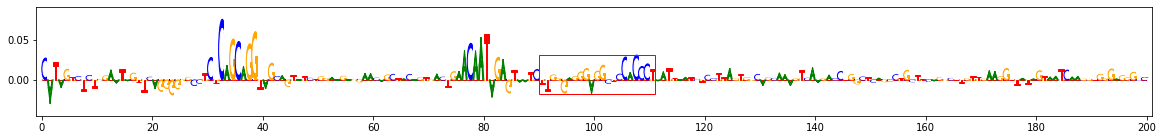

13955 743 3.0757293997409163 0.9908978796705675
slice(653, 853, None)


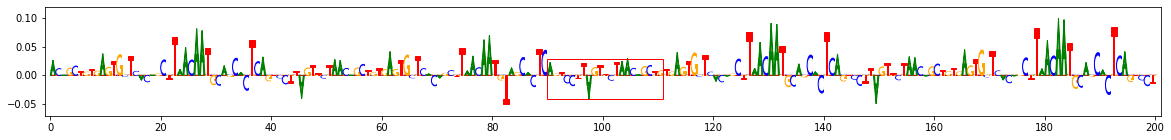

18576 155 3.236580692239847 0.9902179664484826
slice(65, 265, None)


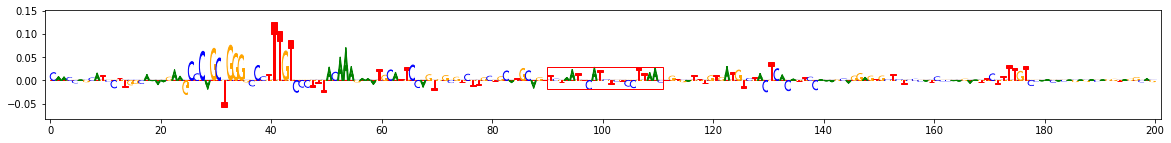

19312 227 3.1804647502608927 0.9550771396536203
slice(137, 337, None)


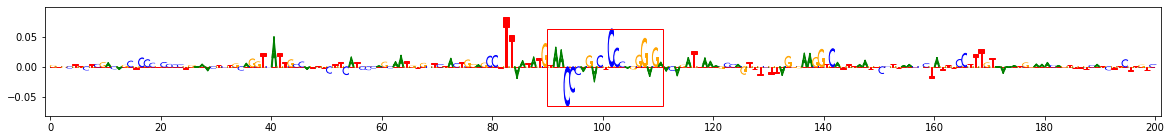

19780 84 3.4948587074828414 0.984397481299268
slice(0, 194, None)


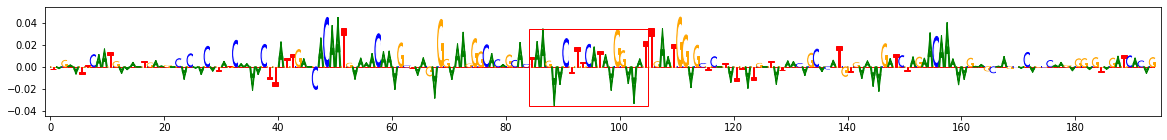

24084 326 3.284005342167937 0.9015034026014649
slice(236, 436, None)


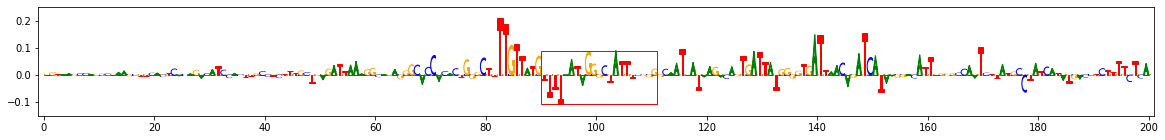

24095 120 3.0268808322030907 0.836728015540874
slice(30, 230, None)


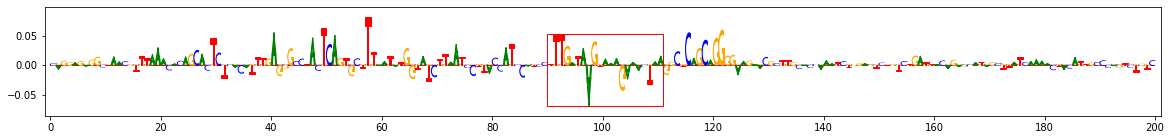

24454 915 3.055526013652593 0.9844812814889932
slice(825, 1000, None)


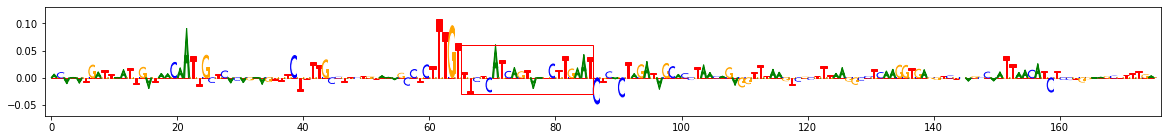

24628 255 3.4437061850355106 0.8727742666395462
slice(165, 365, None)


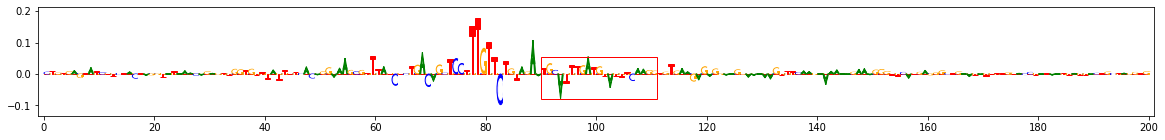

26905 330 3.236580692239847 0.8938177885393648
slice(240, 440, None)


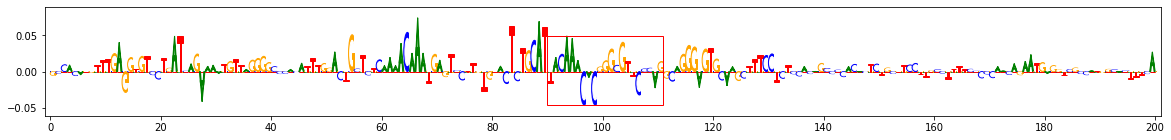

29611 205 3.0268808322030907 0.9908128322832591
slice(115, 315, None)


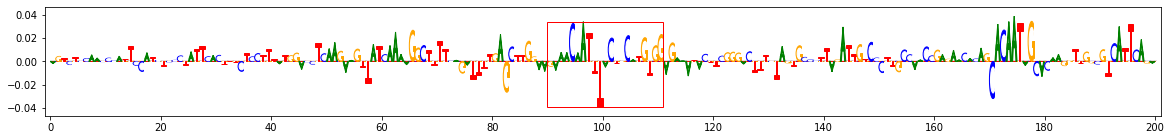

30061 261 3.0655102345592398 0.9480847697566738
slice(171, 371, None)


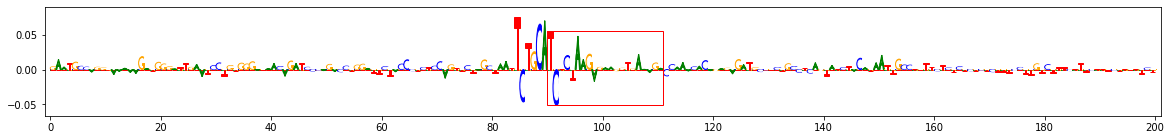

32099 335 3.1804647502608927 0.9609913638053685
slice(245, 445, None)


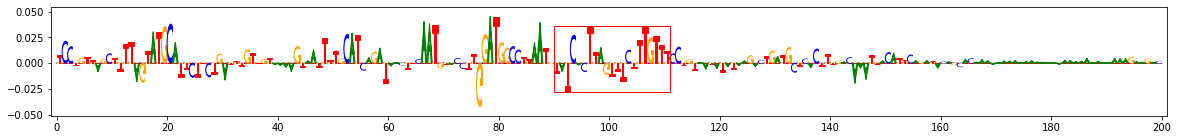

32410 127 3.356556009316574 0.9777453201215217
slice(37, 237, None)


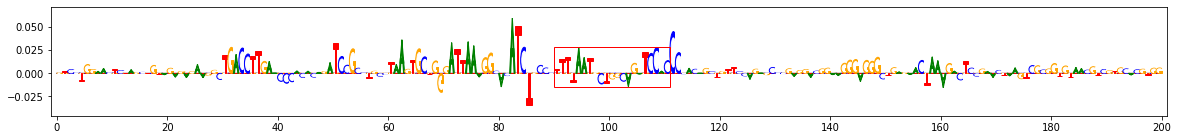

32586 209 3.0268808322030907 0.9278323413238139
slice(119, 319, None)


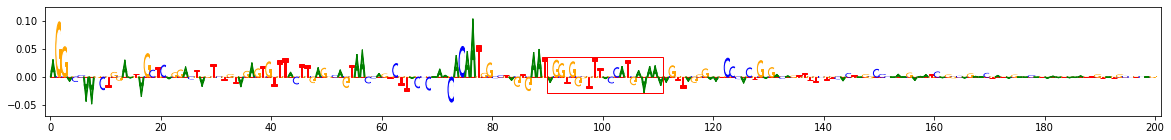

33778 84 3.000008685802766 0.9911531218065678
slice(0, 194, None)


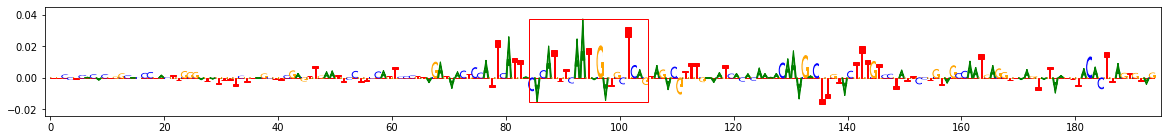

36424 682 3.0177374527632295 0.9419624554074985
slice(592, 792, None)


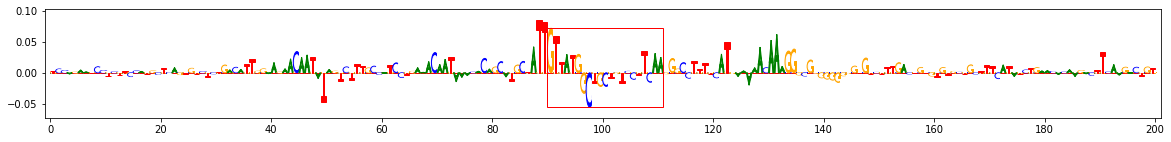

37786 893 3.8538806501246174 0.9887766754834144
slice(803, 1000, None)


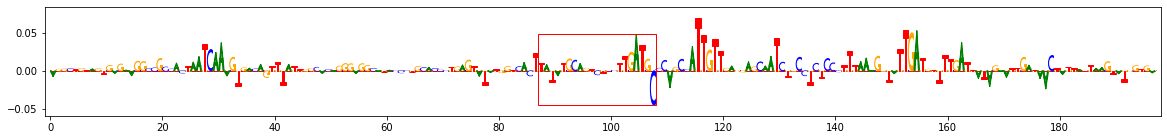

38101 72 3.397948694474876 0.9405210015283334
slice(0, 182, None)


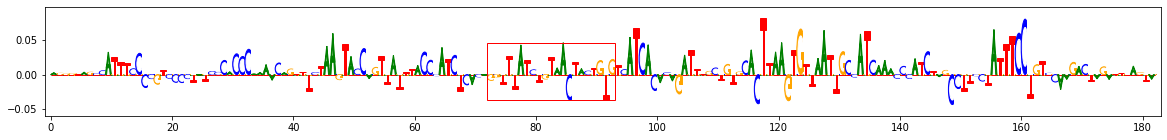

38462 702 3.000008685802766 0.9947423528300113
slice(612, 812, None)


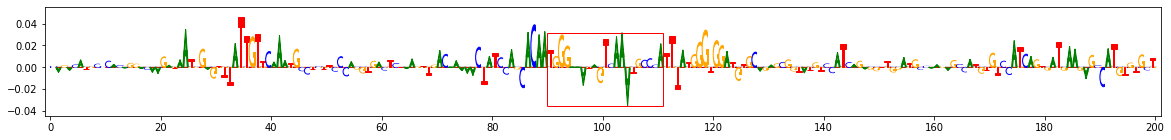

38724 275 3.207616996304557 0.9952575302117791
slice(185, 385, None)


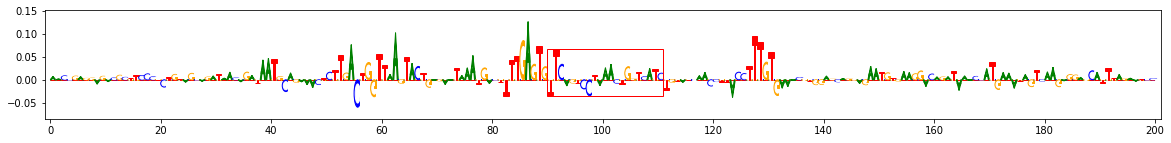

39676 753 3.008782610110262 0.9883536750780022
slice(663, 863, None)


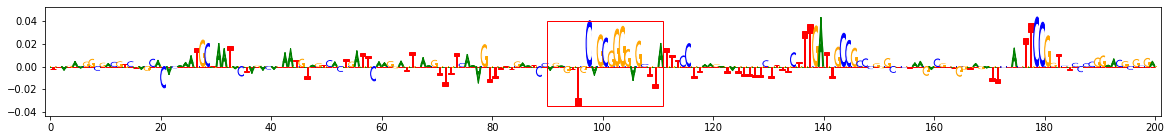

39820 308 3.15491064578853 0.950170685180197
slice(218, 418, None)


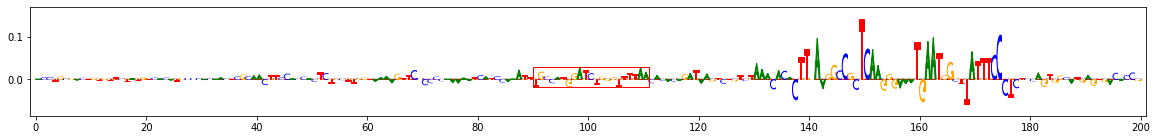

40258 95 3.1079140831122865 0.8951120558538148
slice(5, 205, None)


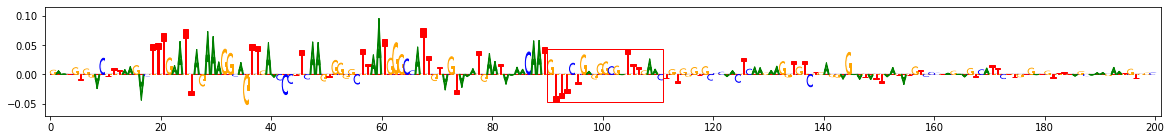

40421 109 3.0969186988108346 0.9569609429986609
slice(19, 219, None)


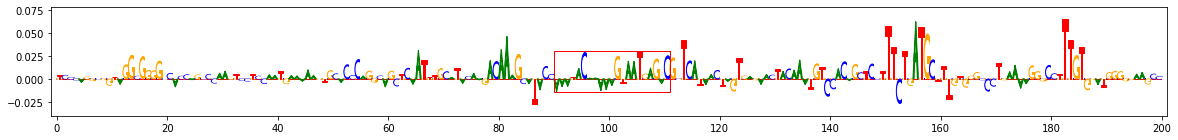

41821 296 3.0655102345592398 0.9890306736280379
slice(206, 406, None)


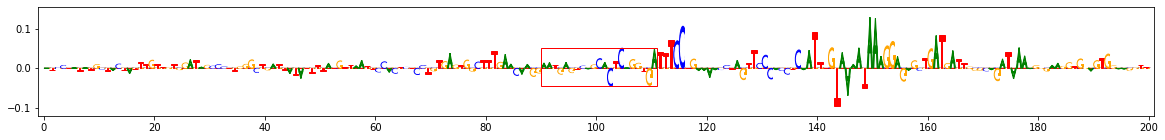

42098 254 3.0457661763634465 0.7995959846055339
slice(164, 364, None)


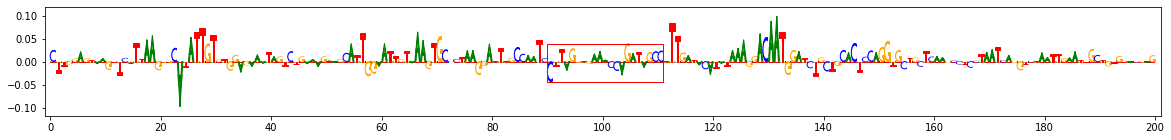

43322 42 3.251820658796569 0.8534465726452236
slice(0, 152, None)


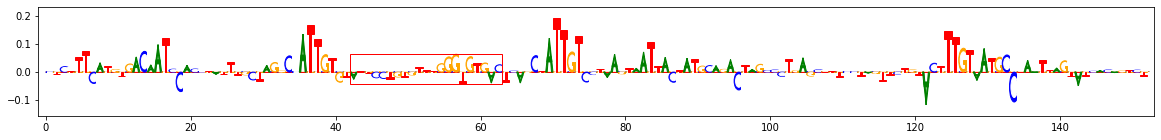

43471 101 3.4437061850355106 0.9368254978352043
slice(11, 211, None)


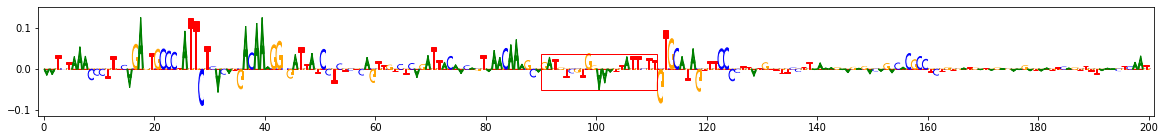

45474 927 3.0969186988108346 0.842068629838013
slice(837, 1000, None)


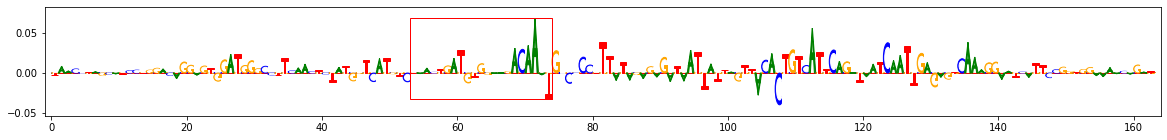

46295 132 3.3187674484272107 0.9857402285931371
slice(42, 242, None)


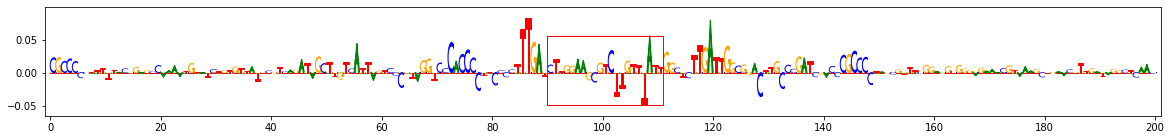

46395 136 3.236580692239847 0.8274641314304172
slice(46, 246, None)


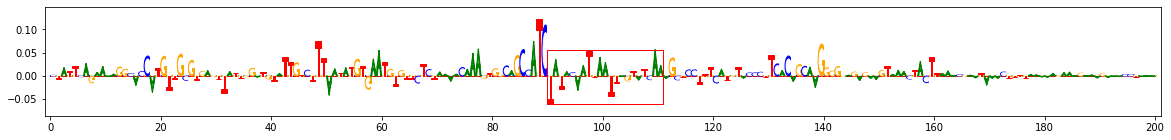

47144 78 3.19382871181886 0.9770856739238415
slice(0, 188, None)


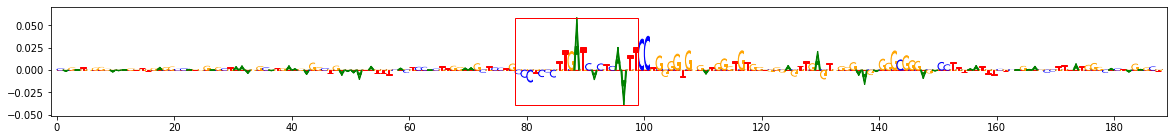

47390 193 3.0969186988108346 0.8953850253674545
slice(103, 303, None)


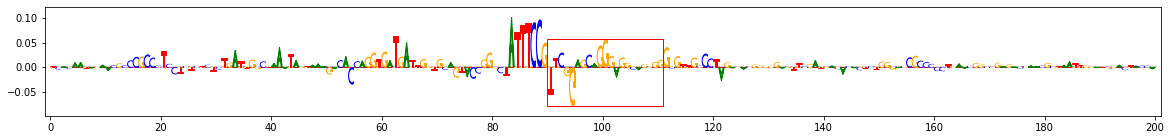

47538 869 3.284005342167937 0.8895536613417647
slice(779, 979, None)


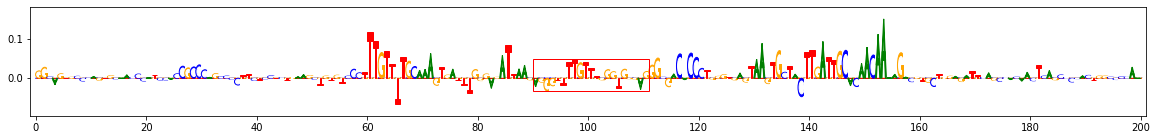

47561 882 3.0177374527632295 0.9490878488673772
slice(792, 992, None)


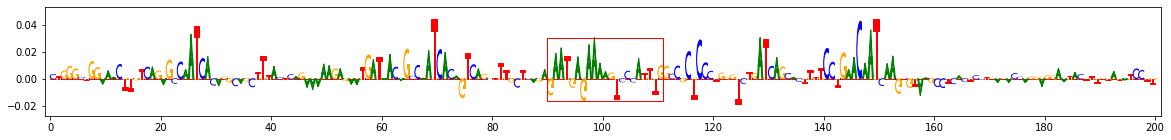

47730 816 3.585035337832011 0.9920902951571815
slice(726, 926, None)


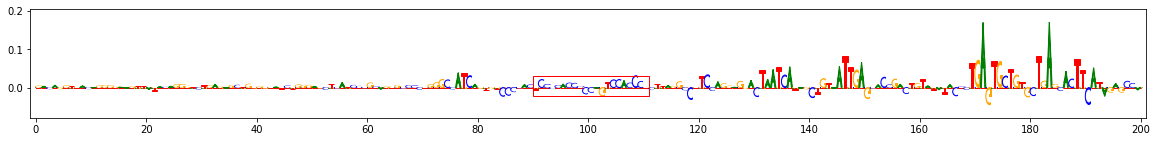

47842 945 3.055526013652593 0.987677730222633
slice(855, 1000, None)


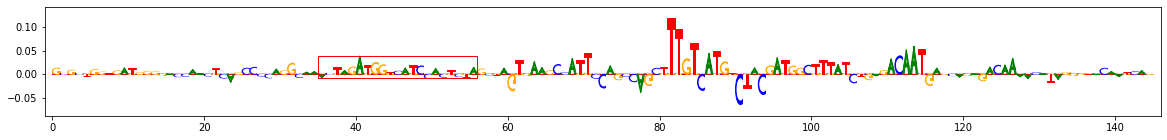

49671 89 3.9208274397551732 0.8695462565212007
slice(0, 199, None)


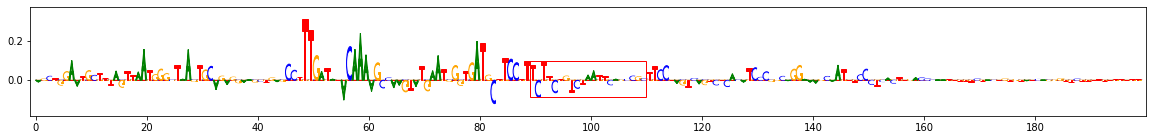

50661 51 3.552850654460636 0.960118888066599
slice(0, 161, None)


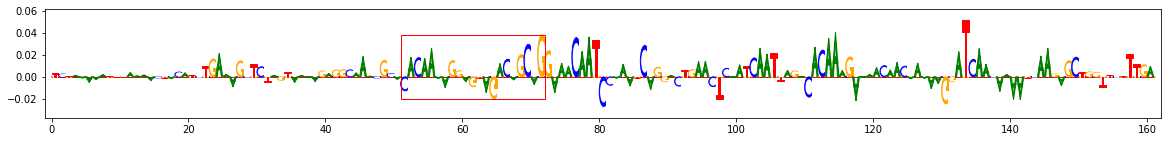

51178 196 3.1079140831122865 0.9058171608932485
slice(106, 306, None)


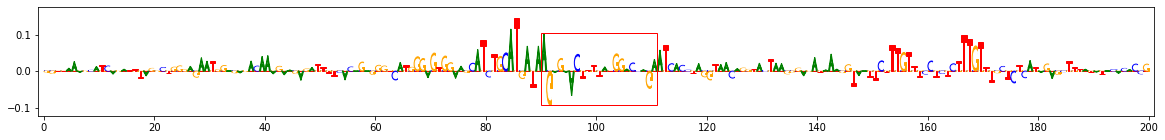

51676 158 3.19382871181886 0.9447068214553397
slice(68, 268, None)


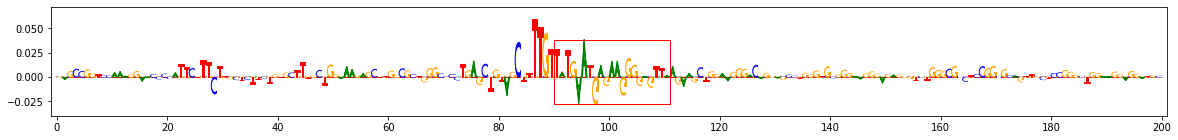

51932 260 3.0457661763634465 0.9664241102873671
slice(170, 370, None)


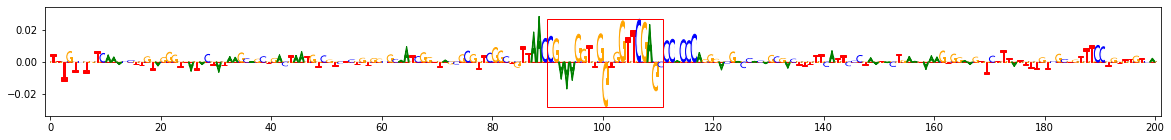

53040 817 3.356556009316574 0.9888613250269829
slice(727, 927, None)


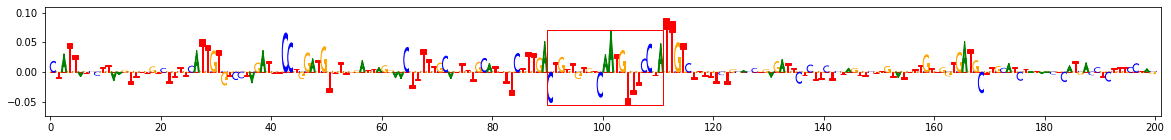

53429 306 3.055526013652593 0.8822072778054526
slice(216, 416, None)


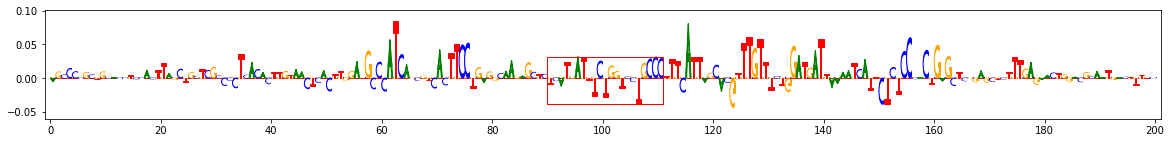

54557 766 3.1079140831122865 0.9507906631325985
slice(676, 876, None)


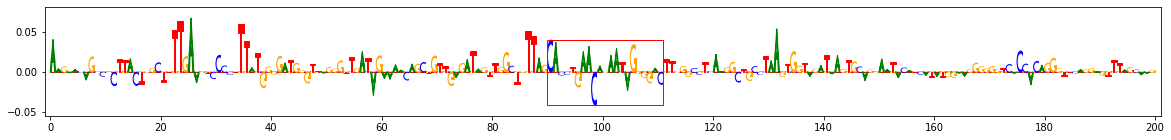

55166 145 3.420225089186009 0.9666653626675564
slice(55, 255, None)


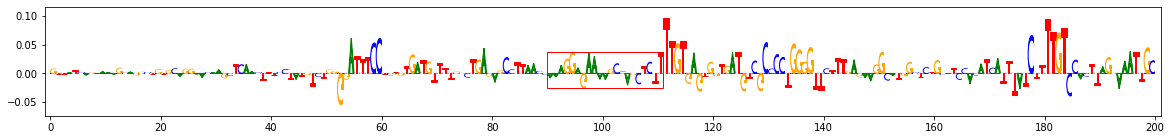

55170 844 3.236580692239847 0.7058953294407372
slice(754, 954, None)


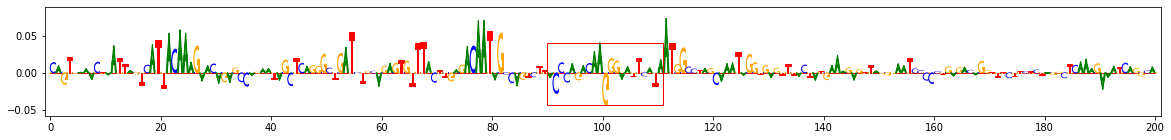

55224 968 3.236580692239847 0.9758515313431076
slice(878, 1000, None)


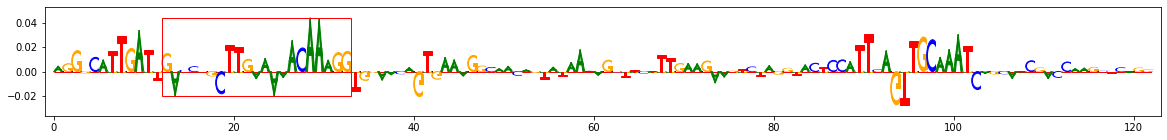

55225 125 3.236580692239847 0.8256580883234002
slice(35, 235, None)


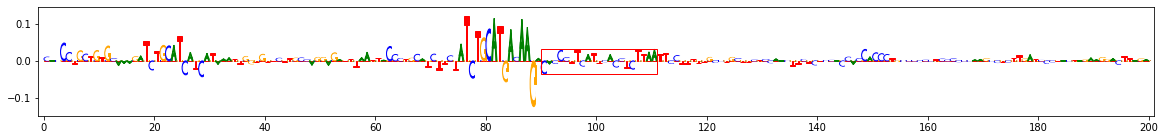

In [140]:
for seqidx, (posidx, _) in seq_to_best_example.items():
    print(seqidx, posidx,
          logperc_transformed_perseq_windowsum[seqidx, posidx],
          logperc_normal_perseq_windowsum[seqidx, posidx])
    center = posidx + int(window_size/2)
    leftflank = center - max(0,center-100)
    rightflank = min(1000,center+100) - center
    flank = min(leftflank, rightflank)                    
    the_slice = slice(center-leftflank, center+rightflank)
    print(the_slice)
    #viz_sequence.plot_weights( (transformed_perseq[seqidx][:,None]
    #                            *onehot_seq[seqidx])[the_slice], subticks_frequency=20)
    viz_sequence.plot_weights( nanog_profile_wn_contribs[seqidx][the_slice], subticks_frequency=20,
                               highlight={'red': [(flank-int(window_size/2), flank-int(window_size/2)+window_size)]})

50

In [119]:
rank_disagreements[0][:10]

array([ 401,  529,  529,  704, 1575, 2245, 2513, 2513, 2513, 2513])

In [120]:
rank_disagreements[1][:10]

array([772, 163, 181, 668, 782, 402, 210, 245, 250, 251])

In [99]:
transformed_perseq_windowsum[5,485]

14.128010830126641

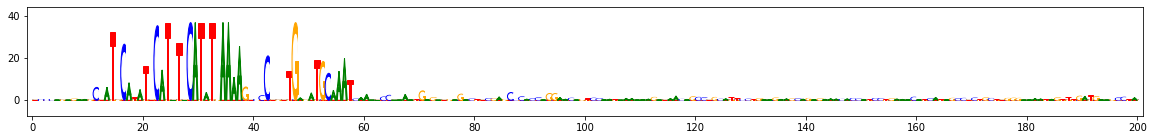

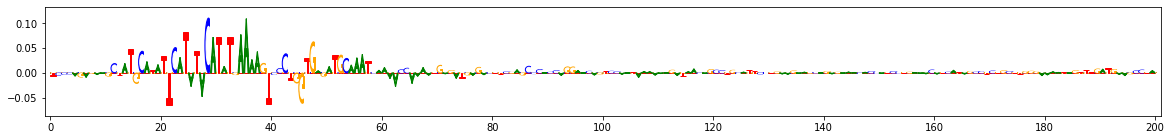

In [121]:
from modisco.visualization import viz_sequence

#sort indices by the sum of imp scores
indices_sorted_by_sumimp = np.argsort(np.sum(nanog_profile_wn_contribs, axis=(1,2)))

idx = 2245#indices_sorted_by_sumimp[-2000]
the_slice = slice(400,600)
viz_sequence.plot_weights( (transformed_perseq[idx][:,None]
                            *onehot_seq[idx])[the_slice], subticks_frequency=20)
viz_sequence.plot_weights( nanog_profile_wn_contribs[idx][the_slice], subticks_frequency=20 )

In [18]:
mad_dist = [scipy.stats.median_absolute_deviation(np.sum(x, axis=-1)) for x in nanog_profile_wn_contribs]

In [22]:
max_dist = [np.max(np.sum(x, axis=-1)) for x in nanog_profile_wn_contribs]

In [24]:
mad_dist_abs = [scipy.stats.median_absolute_deviation(np.abs(np.sum(x, axis=-1)) ) for x in nanog_profile_wn_contribs]
max_dist_abs = [np.max(np.abs(np.sum(x, axis=-1))) for x in nanog_profile_wn_contribs]

In [33]:
mad_dist_central = [scipy.stats.median_absolute_deviation(np.sum(x, axis=-1)[400:600])
                    for x in nanog_profile_wn_contribs]

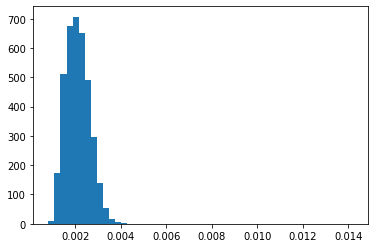

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(mad_dist, bins=50, density=True)
plt.show()

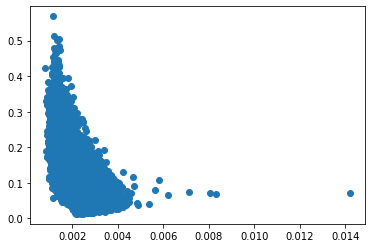

In [23]:
plt.scatter(mad_dist, max_dist)
plt.show()

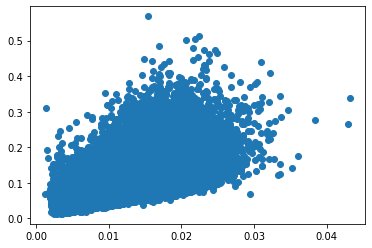

In [34]:
plt.scatter(mad_dist_central, max_dist)
plt.show()